In [21]:
from cmr import GranuleQuery
import datetime
from shapely.geometry import box
import pandas as pd
import geopandas as gpd
from tqdm import tqdm
from osgeo import gdal
import rasterio
import concurrent.futures
import backoff

# GDAL configs used to successfully access LP DAAC Cloud Assets via vsicurl 
gdal.SetConfigOption("GDAL_HTTP_UNSAFESSL", "YES")
gdal.SetConfigOption('GDAL_HTTP_COOKIEFILE','~/cookies.txt')
gdal.SetConfigOption('GDAL_HTTP_COOKIEJAR', '~/cookies.txt')
gdal.SetConfigOption('GDAL_DISABLE_READDIR_ON_OPEN','YES')
gdal.SetConfigOption('GDAL_DISABLE_READDIR_ON_OPEN','FALSE')
gdal.SetConfigOption('CPL_VSIL_CURL_ALLOWED_EXTENSIONS','TIF')

# Constants

In [2]:
HLS_S30_CONCEPT_ID = 'C2021957295-LPCLOUD'
HLS_L30_CONCEPT_ID = 'C2021957657-LPCLOUD'
DSWX_CONCEPT_ID = 'C2617126679-POCLOUD'

# Parameters

In [3]:
now = datetime.datetime.now()
delta = datetime.timedelta(days=7)

beg_date = now - delta
end_date = now

# DSWx Metadata

In [4]:
api = GranuleQuery()

In [5]:
q = api.concept_id(DSWX_CONCEPT_ID)
q = q.temporal(beg_date, end_date)

In [6]:
q.hits()

50566

In [7]:
%%time

dswx_metadata = q.get_all()

CPU times: user 8.89 s, sys: 3.88 s, total: 12.8 s
Wall time: 2min 19s


In [8]:
dswx_metadata[0]

{'producer_granule_id': 'OPERA_L3_DSWx-HLS_T25MER_20230504T123259Z_20230506T164750Z_S2B_30_v1.0',
 'boxes': ['-4.524 -33 -3.53 -32.01'],
 'time_start': '2023-05-04T12:33:08.845Z',
 'updated': '2023-05-06T16:51:17.371Z',
 'dataset_id': 'OPERA Dynamic Surface Water Extent from Harmonized Landsat Sentinel-2 provisional product (Version 1)',
 'data_center': 'POCLOUD',
 'title': 'OPERA_L3_DSWx-HLS_T25MER_20230504T123259Z_20230506T164750Z_S2B_30_v1.0',
 'coordinate_system': 'CARTESIAN',
 'day_night_flag': 'UNSPECIFIED',
 'time_end': '2023-05-04T12:33:08.845Z',
 'id': 'G2679801187-POCLOUD',
 'original_format': 'UMM_JSON',
 'granule_size': '3.0517578125E-5',
 'browse_flag': True,
 'collection_concept_id': 'C2617126679-POCLOUD',
 'online_access_flag': True,
 'links': [{'rel': 'http://esipfed.org/ns/fedsearch/1.1/browse#',
   'title': 'Download OPERA_L3_DSWx-HLS_T25MER_20230504T123259Z_20230506T164750Z_S2B_30_v1.0_BROWSE.png',
   'hreflang': 'en-US',
   'href': 'https://archive.podaac.earthdata.

## Formatting

In [9]:
def format_dswx(item):
    out = {}
    granule_id = item['producer_granule_id']
    out['granule_id'] = granule_id
    out['time_acquired'] = pd.to_datetime(item['time_start'])
    out['time_updated'] = pd.to_datetime(item['updated'])
    out['B01_WTR_link'] = next(link_data['href'] for link_data in item['links'] 
                           if all(kw in link_data['href'] for kw in ['B01_WTR', 'https://']))
    
    bbox_str = item['boxes'][0].split(' ')
    bbox_floats = [float(coord) for coord in bbox_str]
    out['time_acq_str'] = granule_id.split('_')[4]
    out['mgrs_tile_id'] = granule_id.split('_')[3]
    ymin, xmin, ymax, xmax = bbox_floats
    # Fix dateline issues
    if abs(xmax - xmin) > 180:
        xmin = min(xmax, xmin)
        xmax = max(xmax, xmin)
        xmax = xmax - 360
    out['geometry'] = box(xmin, ymin, xmax, ymax)
    return out

In [11]:
dswx_data_formatted = list(map(format_dswx, tqdm(dswx_metadata)))

100%|███████████████████████████████████████████████████████████████████████████████████████████| 50596/50596 [01:06<00:00, 759.60it/s]


In [12]:
df = gpd.GeoDataFrame(dswx_data_formatted)
df.head()

,granule_id,time_acquired,time_updated,B01_WTR_link,time_acq_str,mgrs_tile_id,geometry
0,OPERA_L3_DSWx-HLS_T25MER_20230504T123259Z_2023...,2023-05-04 12:33:08.845000+00:00,2023-05-06 16:51:17.371000+00:00,https://archive.podaac.earthdata.nasa.gov/poda...,20230504T123259Z,T25MER,"POLYGON ((-32.01000 -4.52400, -32.01000 -3.530..."
1,OPERA_L3_DSWx-HLS_T42XVQ_20230504T125639Z_2023...,2023-05-04 12:56:39.187000+00:00,2023-05-06 08:15:15.550000+00:00,https://archive.podaac.earthdata.nasa.gov/poda...,20230504T125639Z,T42XVQ,"POLYGON ((69.57000 80.12500, 69.57000 81.14800..."
2,OPERA_L3_DSWx-HLS_T41XNK_20230504T125639Z_2023...,2023-05-04 12:56:39.187000+00:00,2023-05-06 08:15:16.575000+00:00,https://archive.podaac.earthdata.nasa.gov/poda...,20230504T125639Z,T41XNK,"POLYGON ((69.36600 80.11600, 69.36600 81.14900..."
3,OPERA_L3_DSWx-HLS_T42XVR_20230504T125639Z_2023...,2023-05-04 12:56:39.187000+00:00,2023-05-08 02:12:16.707000+00:00,https://archive.podaac.earthdata.nasa.gov/poda...,20230504T125639Z,T42XVR,"POLYGON ((69.63400 81.01600, 69.63400 82.04400..."
4,OPERA_L3_DSWx-HLS_T40XER_20230504T125639Z_2023...,2023-05-04 12:56:39.187000+00:00,2023-05-08 02:13:14.809000+00:00,https://archive.podaac.earthdata.nasa.gov/poda...,20230504T125639Z,T40XER,"POLYGON ((64.07000 81.00700, 64.07000 82.04500..."


<Axes: >

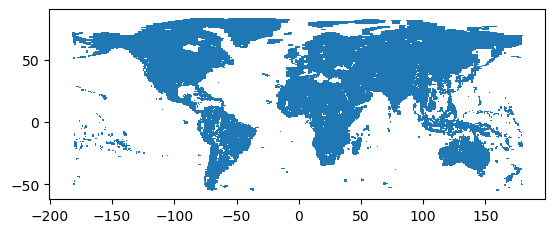

In [13]:
df.plot()

In [14]:
# df.to_file('dswx_metadata.geojson', driver='GeoJSON')

## Compute nodata pixels

In [22]:
def get_tag_data(url: str) -> dict:
    with rasterio.open(url) as ds:
        t = ds.tags()
    out = {key.lower(): val for key, val in t.items()}
    return out

@backoff.on_exception(backoff.expo,
                      Exception,
                      max_tries=10)
def get_tag_data_from_item(item: dict) -> dict:
    url = item['B01_WTR_link']
    return get_tag_data(url)

Sequentially:

In [23]:
# tag_info = list(map(get_tag_data_from_item, tqdm(dswx_data_formatted[:4])))
# tag_info

Multithreading:

In [24]:
n = len(dswx_data_formatted)
with concurrent.futures.ThreadPoolExecutor(max_workers=100) as executor:
    tag_info = list(tqdm(executor.map(get_tag_data_from_item, dswx_data_formatted[:]), total=n))

100%|████████████████████████████████████████████████████████████████████████████████████████████| 50596/50596 [23:17<00:00, 36.21it/s]


In [26]:
dswx_data_formatted_plus_tags = [{**item, **tag_item} for (item, tag_item) in zip(dswx_data_formatted, tag_info)]
df_tags = gpd.GeoDataFrame(dswx_data_formatted_plus_tags)

In [27]:
df_tags.to_file('dswx_metadata_with_tags.geojson', driver='GeoJSON')

In [28]:
df_tags.shape

(50596, 51)